In [4]:
import arrayworm as aw
import importlib as imp
imp.reload(aw)


<module 'arrayworm' from '/home/hornung/projects/pyworm/arrayworm.py'>

In [8]:
import cProfile
def test_run():
    imp.reload(aw)
    testlat = aw.Lattice(beta=1,s1=2,s2=2, ics=["u","u"], mu3=1)

    for i in range(10000):
        tw = aw.Worm(testlat)
        tw.run()
cpr = cProfile.Profile()    
cpr.enable()
test_run()
cpr.disable()
cpr.print_stats(sort='cumtime')
cpr.print_stats


         6472261 function calls (6472254 primitive calls) in 7.036 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    7.036    3.518 interactiveshell.py:2933(run_code)
      5/2    0.000    0.000    7.036    3.518 {built-in method builtins.exec}
        1    0.000    0.000    7.036    7.036 <ipython-input-8-31b963d9c702>:11(<module>)
        1    0.037    0.037    7.036    7.036 <ipython-input-8-31b963d9c702>:2(test_run)
    10000    0.104    0.000    6.682    0.001 arrayworm.py:415(run)
    98095    0.462    0.000    6.577    0.000 arrayworm.py:393(step)
    98095    0.443    0.000    2.196    0.000 arrayworm.py:371(get_decay_constants)
    98095    0.364    0.000    1.477    0.000 arrayworm.py:343(find_time_to_nextevents)
    98095    0.308    0.000    1.355    0.000 arrayworm.py:382(sample_decay_time)
  1079045    0.841    0.000    1.139    0.000 arrayworm.py:40(find_event_in_dir)
    98095 

<bound method Profile.print_stats of <cProfile.Profile object at 0x7f9c35103798>>

In [117]:
import csv
def tsqfromfile(beta):
    data =[]
    with open('/scratch1/hornung/dtvspyworm/ct/su3/results/BETAS-{0:.2f}.dat'.format(beta)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\t')
        for row in readCSV:
            data = row
    
    return float(data[4])


betacts = [b*0.05 for b in range(1,41)]
t3wqcts = [tsqfromfile(beta) for beta in betacts ]

In [29]:
imp.reload(aw)
from numpy import linspace
from joblib import Parallel, delayed
import multiprocessing
import exactdiag as ed
imp.reload(ed)
num_cores = multiprocessing.cpu_count()
from timeit import default_timer as timer

start = timer()

mu3s = linspace(0.,8,21)
betas = range(1,9)

pywormresults = {}

for beta in betas:
    t3pyworm = Parallel(n_jobs=num_cores)(delayed(aw.launch_simulation)(
                        beta=beta,mu3=mu3,termsteps=100000, wormruns=2000000, ics =["d","u"]) for mu3 in mu3s)
    pywormresults.update({beta:t3pyworm})
    
stop = timer()


print(stop-start)


56895.542214794084


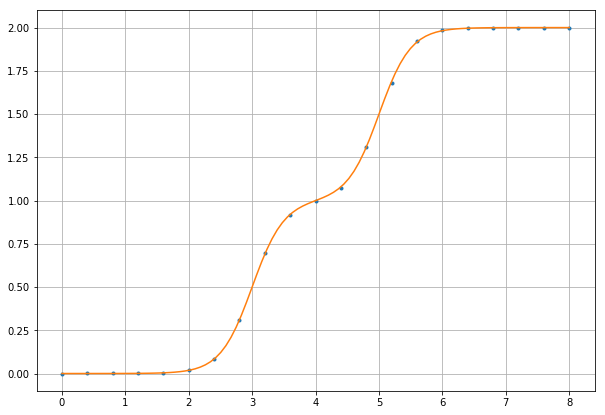

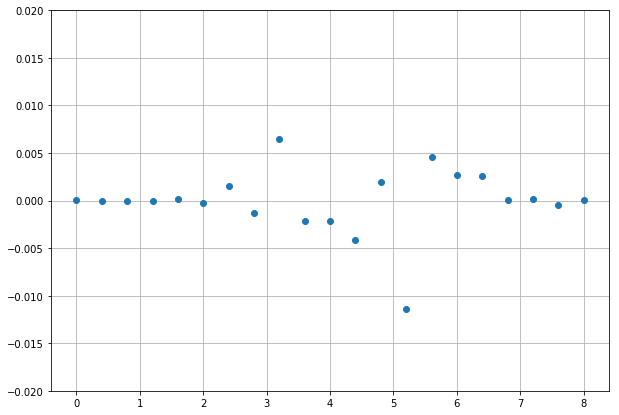

In [46]:
from matplotlib import pyplot as plt
ind = 4
mu3ed = linspace(0,8,100)
t3ed={beta:[ed.t3_su3(mu3=mu3, beta=beta, J=1) for mu3 in mu3ed] for beta in betas}
plt.figure(figsize=[10,7])
plt.grid(True)
plt.plot(mu3s,pywormresults[ind], '.')
plt.plot(mu3ed,t3ed[ind])
#plt.plot(mu3cts,t3cts)
plt.show()

residues = [ x-y for x,y in zip(pywormresults[ind], [ed.t3_su3(mu3=mu3, beta=ind,J=1) for mu3 in mu3s])]
plt.figure(figsize=[10,7])
plt.plot(mu3s,residues,'o' )
plt.ylim(-0.02,0.02)
plt.grid(True)
plt.show()

In [42]:
import csv
data = [pywormresults[beta] for beta in range(1,9)]
file = open('validation-values.dat', 'w')
with file:
    writer = csv.writer(file)
    writer.writerows(data)
     